In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [20]:
start_year = 1928
end_year = 2024

presidential_cycle = {}

year_types = ["Election Year", "1st year", "2nd year", "3rd year"]

for year in range(end_year, start_year-1, -1):
    presidential_cycle[year] = year_types[(year - start_year) % 4]

presidential_years = {
    "Election Year": [],
    "1st year": [],
    "2nd year": [],
    "3rd year": []
}

for year, term_year in presidential_cycle.items():
    presidential_years[term_year].append(year)

In [21]:
def load_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close']


In [22]:
def calculate_average_yield(presidential_years, yield_data):
    average_yields = {'Election Year': 0, '1st year': 0, '2nd year': 0, '3rd year': 0}
    years_count = {'Election Year': 0, '1st year': 0, '2nd year': 0, '3rd year': 0}

    for year_type, years in presidential_years.items():
        for year in years:
            mask = (yield_data.index.year == year)
            if any(mask):
                average_yields[year_type] += yield_data.loc[mask].values[0]
                years_count[year_type] += 1

    for year_type in average_yields.keys():
        if years_count[year_type] != 0:
            average_yields[year_type] /= years_count[year_type]

    return average_yields

In [23]:
# get data
data = load_data('^GSPC', '1928-01-01', '2012-12-31')

# calculate yearly returns
yield_data = (1 + data.pct_change()).resample('Y').prod() - 1

# calculate average yields
average_yields = calculate_average_yield(presidential_years, yield_data)

print(average_yields)

[*********************100%***********************]  1 of 1 completed
{'Election Year': 0.0687854843019551, '1st year': 0.03964156227345527, '2nd year': 0.04485838292316945, '3rd year': 0.13456145500749722}


In [24]:
def plot_average_yields(average_yields, start_year, end_year):
    # Convert the yields to percentages
    average_yields_percentage = {k: v * 100 for k, v in average_yields.items()}

    fig, ax = plt.subplots()
    bars = plt.bar(average_yields_percentage.keys(), average_yields_percentage.values(), color='blue', alpha=0.7)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())

    plt.xlabel('Year Type in Presidential Cycle')
    plt.ylabel('Average Yield (%)')

    plt.title(f'Average Yield by Year Type in Presidential Cycle ({start_year}-{end_year})')
    plt.show()


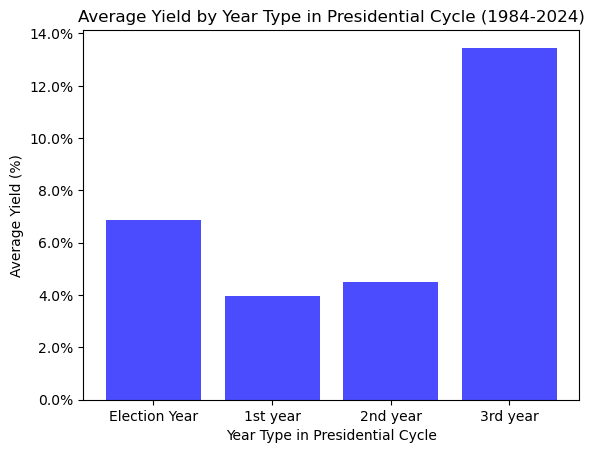

In [25]:
plot_average_yields(average_yields, 1984, 2024)

In [32]:
def plot_average_yields_multi(average_yields_periods):
    df = pd.DataFrame(average_yields_periods).T
    num_groups = len(df.columns)
    num_bars = len(df.index)
    bar_width = 0.2
    indices = np.arange(num_bars)
    colors = plt.cm.Pastel1.colors
    fig, ax = plt.subplots(figsize=(10, 5))

    for i, (year_type, data) in enumerate(df.iteritems()):
        bars = ax.bar(indices + i * bar_width, data.values * 100, width=bar_width, 
               label=year_type, color=colors[i % len(colors)], edgecolor='black')
        for bar in bars:
            yval = bar.get_height()
            if yval >= 0:
                ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{round(yval, 2)}%', 
                        color='grey', ha='center', va='bottom')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, yval - 0.01, f'{round(yval, 2)}%', 
                        color='grey', ha='center', va='top')

    ax.set_xticks(indices + num_groups / 2 * bar_width)
    ax.set_xticklabels(df.index)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    ax.set_xlabel('Period')
    ax.set_ylabel('Average Yield (%)')
    ax.legend(title='Year Type in Presidential Cycle')
    plt.tight_layout()
    plt.show()


In [33]:
def calculate_period_presidential_years(presidential_years, start_year, end_year):
    return {year_type: [year for year in years if start_year <= year <= end_year] 
            for year_type, years in presidential_years.items()}

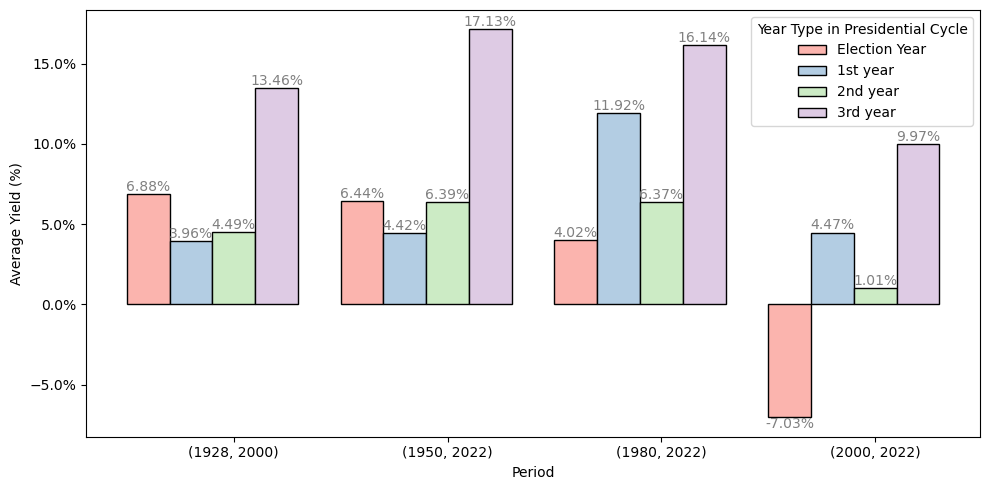

In [34]:
average_yields_periods = {
    (1928, 2000): calculate_average_yield(
        calculate_period_presidential_years(presidential_years, 1928, 2022), 
        yield_data.loc['1928':'2022']
    ),
    (1950, 2022): calculate_average_yield(
        calculate_period_presidential_years(presidential_years, 1950, 2022), 
        yield_data.loc['1950':'2022']
    ),
    (1980, 2022): calculate_average_yield(
        calculate_period_presidential_years(presidential_years, 1980, 2022), 
        yield_data.loc['1980':'2022']
    ),
    (2000, 2022): calculate_average_yield(
        calculate_period_presidential_years(presidential_years, 2000, 2022), 
        yield_data.loc['2000':'2022']
    ),
}

plot_average_yields_multi(average_yields_periods)

In [47]:
def get_yield_data_by_year_type(presidential_cycle, yield_data):
    yield_data_by_year_type = {'Election Year': [], '1st year': [], '2nd year': [], '3rd year': []}
    years = sorted(list(presidential_cycle.keys()))

    for year_type in yield_data_by_year_type:
        for year in years:
            if year in presidential_cycle and presidential_cycle[year] == year_type and str(year) in yield_data.index.year.astype(str):
                yield_value = yield_data.loc[str(year)].values[0]
            else:
                yield_value = np.nan
            yield_data_by_year_type[year_type].append(yield_value)

    return yield_data_by_year_type

yield_data_by_year_type = get_yield_data_by_year_type(presidential_cycle, yield_data)


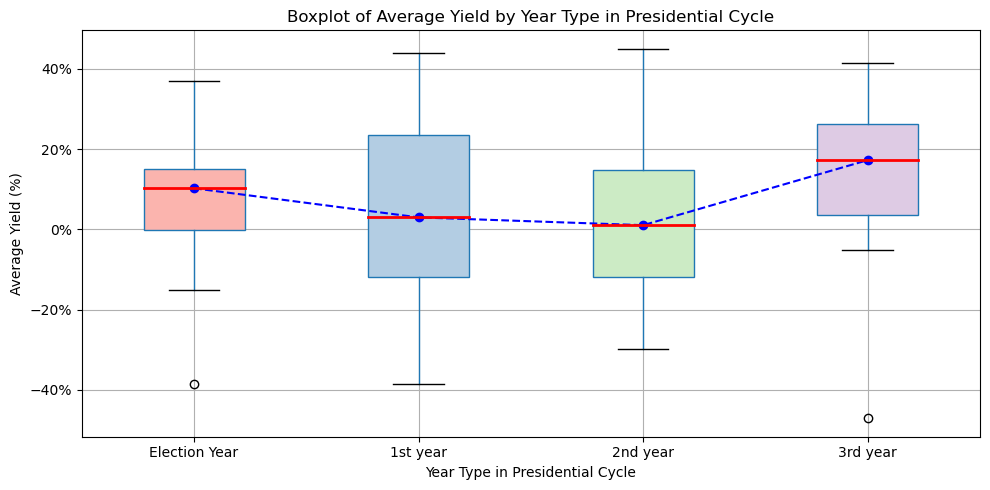

In [52]:
def boxplot_average_yields(yield_data_by_year_type):
    df = pd.DataFrame(yield_data_by_year_type) * 100
    fig, ax = plt.subplots(figsize=(10, 5))

    colors = plt.cm.Pastel1.colors

    # Create a box plot for each column (year type) in the data frame
    boxplot = df.boxplot(patch_artist=True, medianprops={'color':'red', 'linewidth':2}, return_type='dict')

    medians = []
    for i, row in enumerate(boxplot['medians']):
        median = row.get_ydata()[0]
        medians.append(median)
        # Change color of each box
        boxplot['boxes'][i].set_facecolor(colors[i % len(colors)])

    # Draw line connecting medians
    ax.plot(range(1, len(medians)+1), medians, color='blue', linestyle='--', marker='o')

    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    ax.set_xlabel('Year Type in Presidential Cycle')
    ax.set_ylabel('Average Yield (%)')
    ax.set_title('Boxplot of Average Yield by Year Type in Presidential Cycle')
    plt.tight_layout()
    plt.show()

boxplot_average_yields(yield_data_by_year_type)
